I'm aiming to provide a shallow model as a baseline to compare against the likely large number of deep learning solutions. 

Using principal component analysis as an outlier dectector worked well on the practice dataset for signal-to-background ratios as low as 1:500. BlackBox2 appears to be most similar to the practice dataset, and I am able to find a excess $2.4\sigma$ in it around $m_{jj} \approx 4800$ GeV.

This code is/will be available on Github, see this [repo](https://github.com/christopher-w-murphy/LHC-Olympics-2020)

# Load Data

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
data_path = '/Users/christopherwmurphy/Documents/projects/lhc_olympics/LHC-Olympics-2020/data_processed'

In [3]:
df_bg = pd.read_hdf(os.path.join(data_path, 'processed_eventsLHCO2020backgroundMCPythia.h5'), key='processed')

In [4]:
df_2 = pd.read_hdf(os.path.join(data_path, 'processed_eventsLHCO2020BlackBox2.h5'), key='processed')

# Outlier Detection

Features were selected in `feature_selection.ipynb` (in this directory)

In [5]:
od_cols = ['pt_1', 'pt_2', 'sqrt(tau1(2))/tau1(1)_1', 'tau21_1', 'tau32_1', 'tau43_1', 
           'sqrt(tau1(2))/tau1(1)_2', 'tau21_2', 'tau32_2', 'tau43_2', 'mass_1+mass_2', '|mass_1-mass_2|']

Using Principal Component Analysis as my outlier detector, intentionally avoiding using deep learning

In [6]:
from pyod.models.pca import PCA
from sklearn.preprocessing import QuantileTransformer

Fit an outlier detector to BlackBox2

In [7]:
qt2 = QuantileTransformer()
X_od2 = qt2.fit_transform(df_2[od_cols])
pca_2 = PCA(n_components=11, n_selected_components=1)
pca_2.fit(X_od2)
df_2['pca'] = pca_2.decision_scores_

Fit a 2nd outlier detector to the background dataset and score it on both the background and BlackBox2

In [8]:
qt_bg = QuantileTransformer()
X_od_bg = qt_bg.fit_transform(df_bg[od_cols])
pca_bg = PCA(n_components=11, n_selected_components=1)
pca_bg.fit(X_od_bg)
df_2['pca_bg'] = pca_bg.decision_function(X_od2)
df_bg['pca'] = pca_bg.decision_scores_

Construct histograms

In [9]:
od_hist_bins = np.arange(1950, 6150, 100)
od_quantiles = [0.0, 0.7, 0.9, 0.97, 0.99]

In [10]:
import sys
sys.path.append('../')
from src.analysis import utils

In [11]:
od_hist_2 = utils.get_histograms(df_2, od_hist_bins, quantiles=od_quantiles)
od_hist_2bg = utils.get_histograms(df_2, od_hist_bins, quantiles=od_quantiles, feature='pca_bg')
od_hist_bg = utils.get_histograms(df_bg, od_hist_bins, quantiles=od_quantiles)

Plot the result

In [12]:
import matplotlib.pyplot as plt

In [13]:
%matplotlib notebook

plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.serif'] = "cm"

In [14]:
image_dir = '/Users/christopherwmurphy/Documents/projects/lhc_olympics/LHC-Olympics-2020/images'

- Points: outlier detector
- Solid lines: novelty detector
- Gray dashed lines: background-only outlier detector

The percentage in the legend is the fraction of events with the highest outlier scores that were kept

There is an excess of events around 4800 GeV that grows as the outlier threshold is increased. (There is a 2nd excess around 5400 GeV, but its size varies as the threshold is increased, so I think it's less likely to be a real signal)

<IPython.core.display.Javascript object>


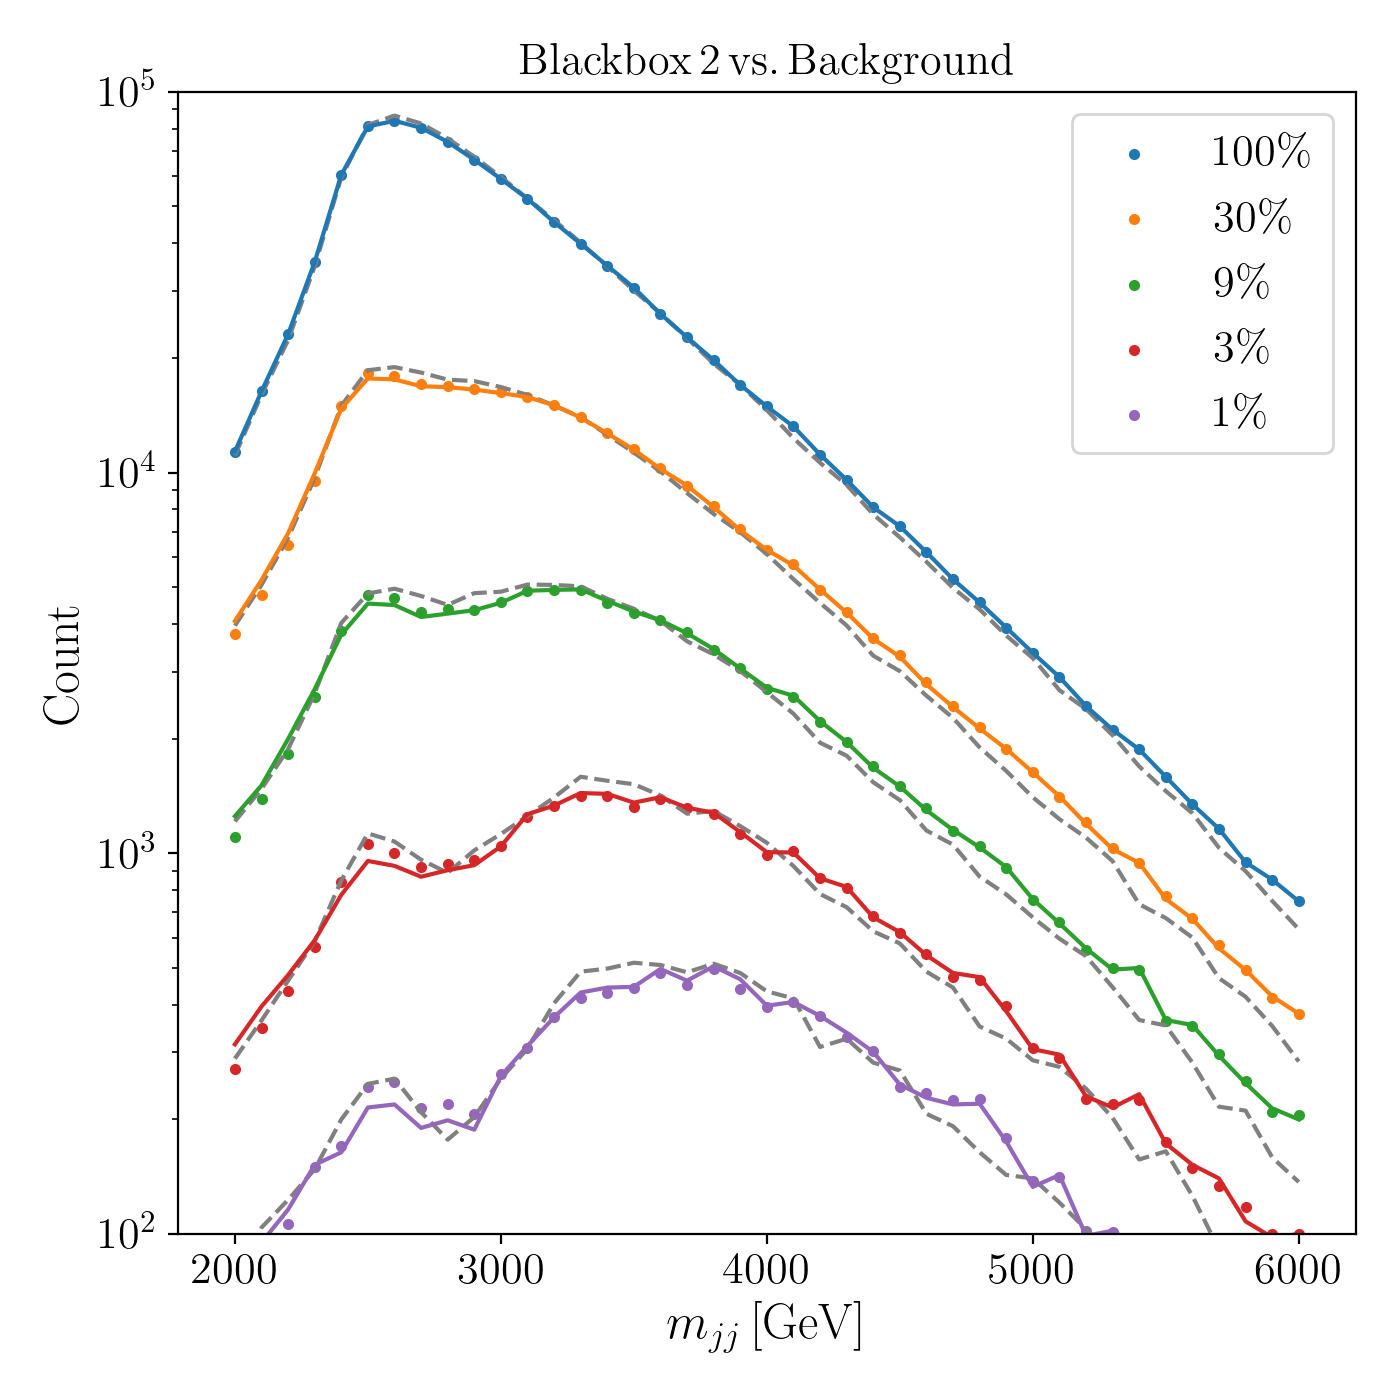

In [15]:
plt.figure(1, figsize=(7, 7))

for hist in od_hist_bg:
    plt.plot(utils.bin_means(hist[1]), hist[0], c='gray', ls='--')
for hist in od_hist_2bg:
    plt.plot(utils.bin_means(hist[1]), hist[0])
for i, hist in enumerate(od_hist_2):
    percentage = int(100*(1-od_quantiles[i]))
    plt.scatter(utils.bin_means(hist[1]), hist[0], marker='.', label=r'${}\%$'.format(percentage))
plt.ylim(10**2, 10**5)
plt.yscale('log')
plt.xlabel(r'$m_{jj}\, \rm [GeV]$')
plt.ylabel(r'$\rm Count $')
plt.title(r'$\rm Blackbox\, 2\, vs.\, Background$')
plt.legend()

plt.tight_layout(True)
plt.savefig(os.path.join(image_dir, 'blackbox2_outlier_detection.png'))
plt.show()

# KPIs

- p-value of no new particles
- Number of  signal events (with uncertainty)
- Description of new particles: mass, decay modes, cross section(?)

## $p$-value of no new particles

In [16]:
from src.analysis.discovery import GetPValue

Define signal and sideband regions

In [17]:
signal_region_center = 4800

signal_region_width = 200
sideband_width = 600
hist_bin_width = 100

signal_region_min = signal_region_center - signal_region_width / 2
signal_region_max = signal_region_center + signal_region_width / 2
sideband_region_min = signal_region_min - sideband_width * 2 / 3
sideband_region_max = signal_region_max + sideband_width * 1 / 3

Compute the $p$-value using the procedure of 1805.02664, 1902.02634

There is a 2.4$\sigma$ excess around 4700-4900 GeV

<IPython.core.display.Javascript object>


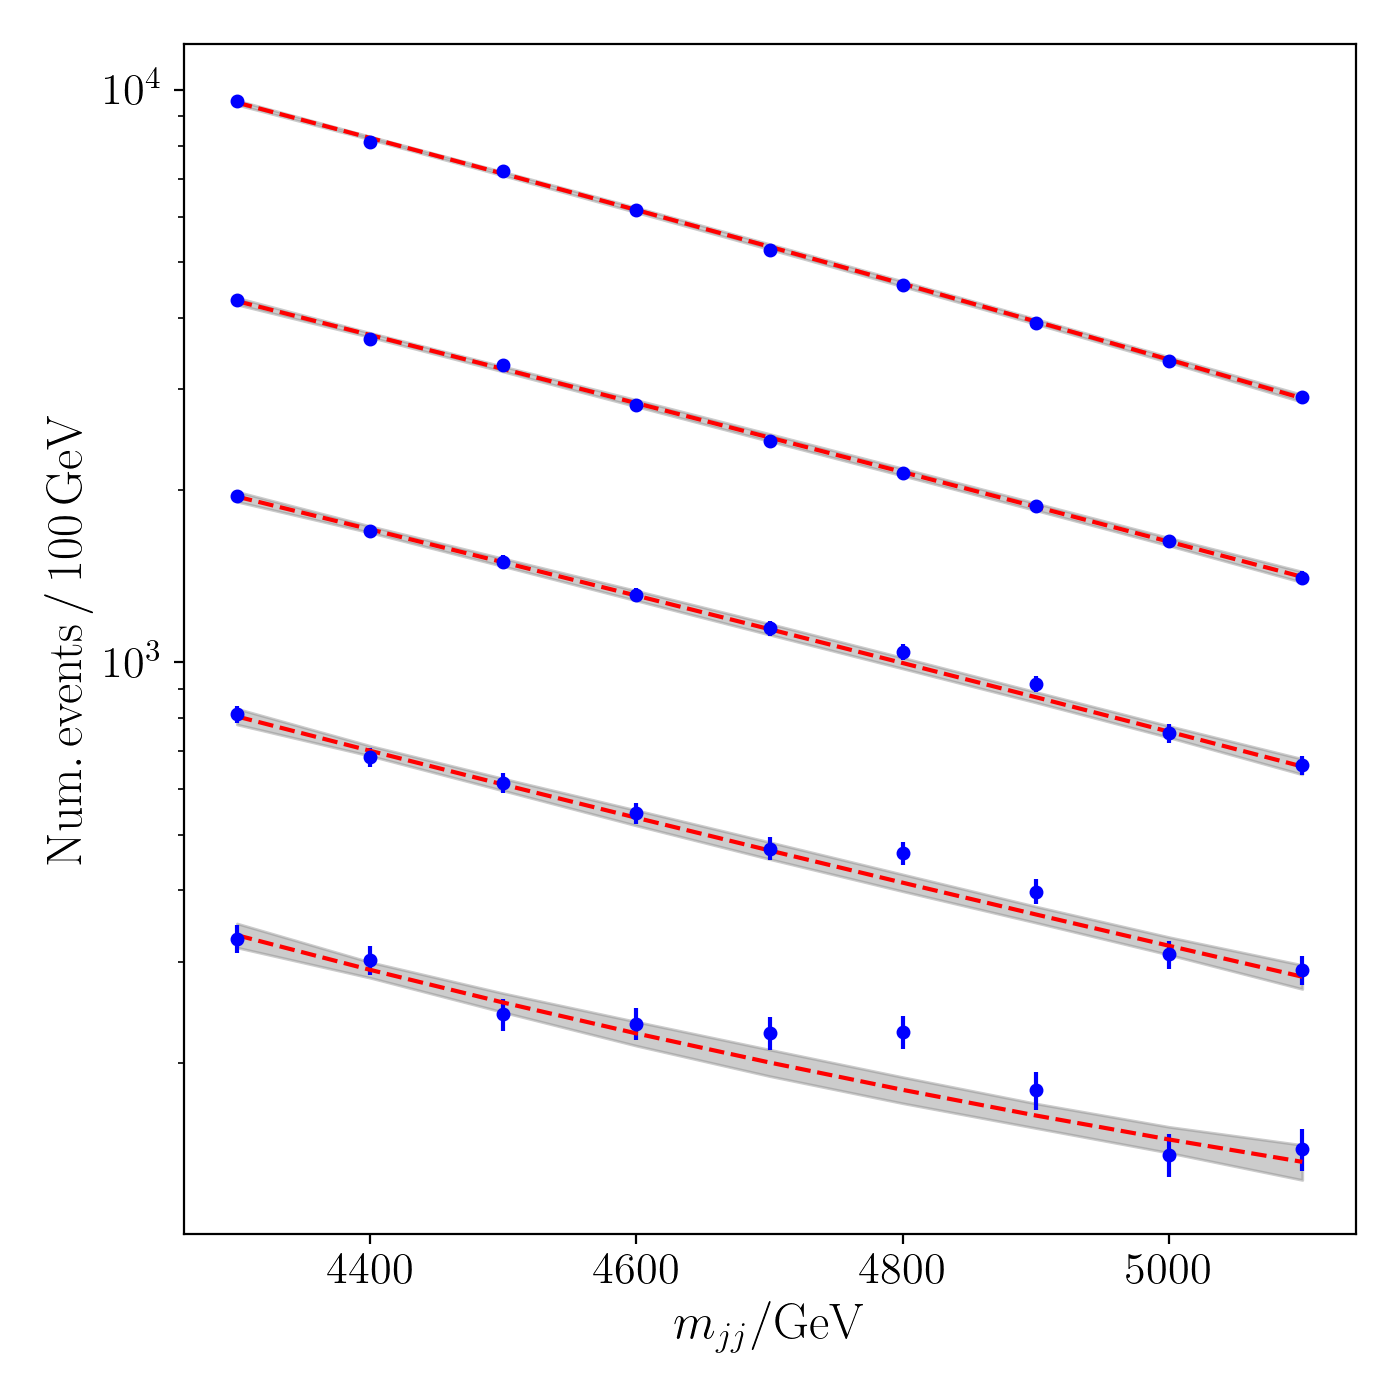

INFO:root:Fit params:
INFO:root:1691326.1869797132
INFO:root:12.55373740760732
INFO:root:-0.12571076740150003
INFO:root:Number of expected events = 13853.929134125066
INFO:root:Number of observed events = 13721.0
INFO:root:Numerator:
INFO:root:fun = -116993.9746174038
INFO:root:jac = [0.01018634]
INFO:root:nfev = 4
INFO:root:nit = 1
INFO:root:status = 0
INFO:root:message = b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
INFO:root:x = [0.00981366]
INFO:root:success = True
INFO:root:hess_inv = <1x1 LbfgsInvHessProduct with dtype=float64>
INFO:root:Denominator:
INFO:root:fun = -116994.5169037225
INFO:root:jac = [-0.00097656  0.00195312]
INFO:root:hess_inv = [[2045.35116354 2044.16697362]
 [2044.16697362 2044.98317303]]
INFO:root:nfev = 177
INFO:root:njev = 42
INFO:root:status = 2
INFO:root:success = False
INFO:root:message = Desired error not necessarily achieved due to precision loss.
INFO:root:x = [-56.61618004 -55.6311802 ]
INFO:root:nit = 4
INFO:root:Zval = 0
INFO:root:p0 = 0.5
INF

In [18]:
plt.figure(2, figsize=(7, 7))
gpv = GetPValue()
for histo in od_hist_2:
    sb_idx_min, sb_idx_max = utils.get_sideband_indices(histo, sideband_region_min, sideband_region_max)
    ydata = histo[0][sb_idx_min:sb_idx_max+1]
    binvals = histo[1][sb_idx_min:sb_idx_max+2]
    od_histo = [ydata, binvals]
    mask = utils.get_mask(od_histo, signal_region_min, signal_region_max)
    try:
        gpv.get_p_value(ydata, binvals, mask, verbose=True, plotfile='show')
    except RuntimeError:
        pass
plt.xlabel(r'$m_{jj} / \rm GeV$')
plt.ylabel(r'$\rm Num.\, events\, /\, {}\, GeV$'.format(hist_bin_width))
plt.title(None)
plt.tight_layout(True)
plt.savefig(os.path.join(image_dir, 'blackbox2_pvalue.png'))
plt.show()

## Number of signal events

This is in the log info above

10% most outlying

In [19]:
(3108 - 3010.55, (3108+1)**0.5)

(97.44999999999982, 55.758407437802596)

3% most outlying

In [20]:
(1336 - 1244.63, (1336+1)**0.5)

(91.36999999999989, 36.565010597564445)

1% most outlying

In [21]:
(630 - 540.88, (630+1)**0.5)

(89.12, 25.11971337416094)

## Description of new particles: mass, decay modes, ...

In what follows, unless otherwise noted, the blue is the full dataset and the orange is the signal region with the 1% of most outlying events selected

<IPython.core.display.Javascript object>


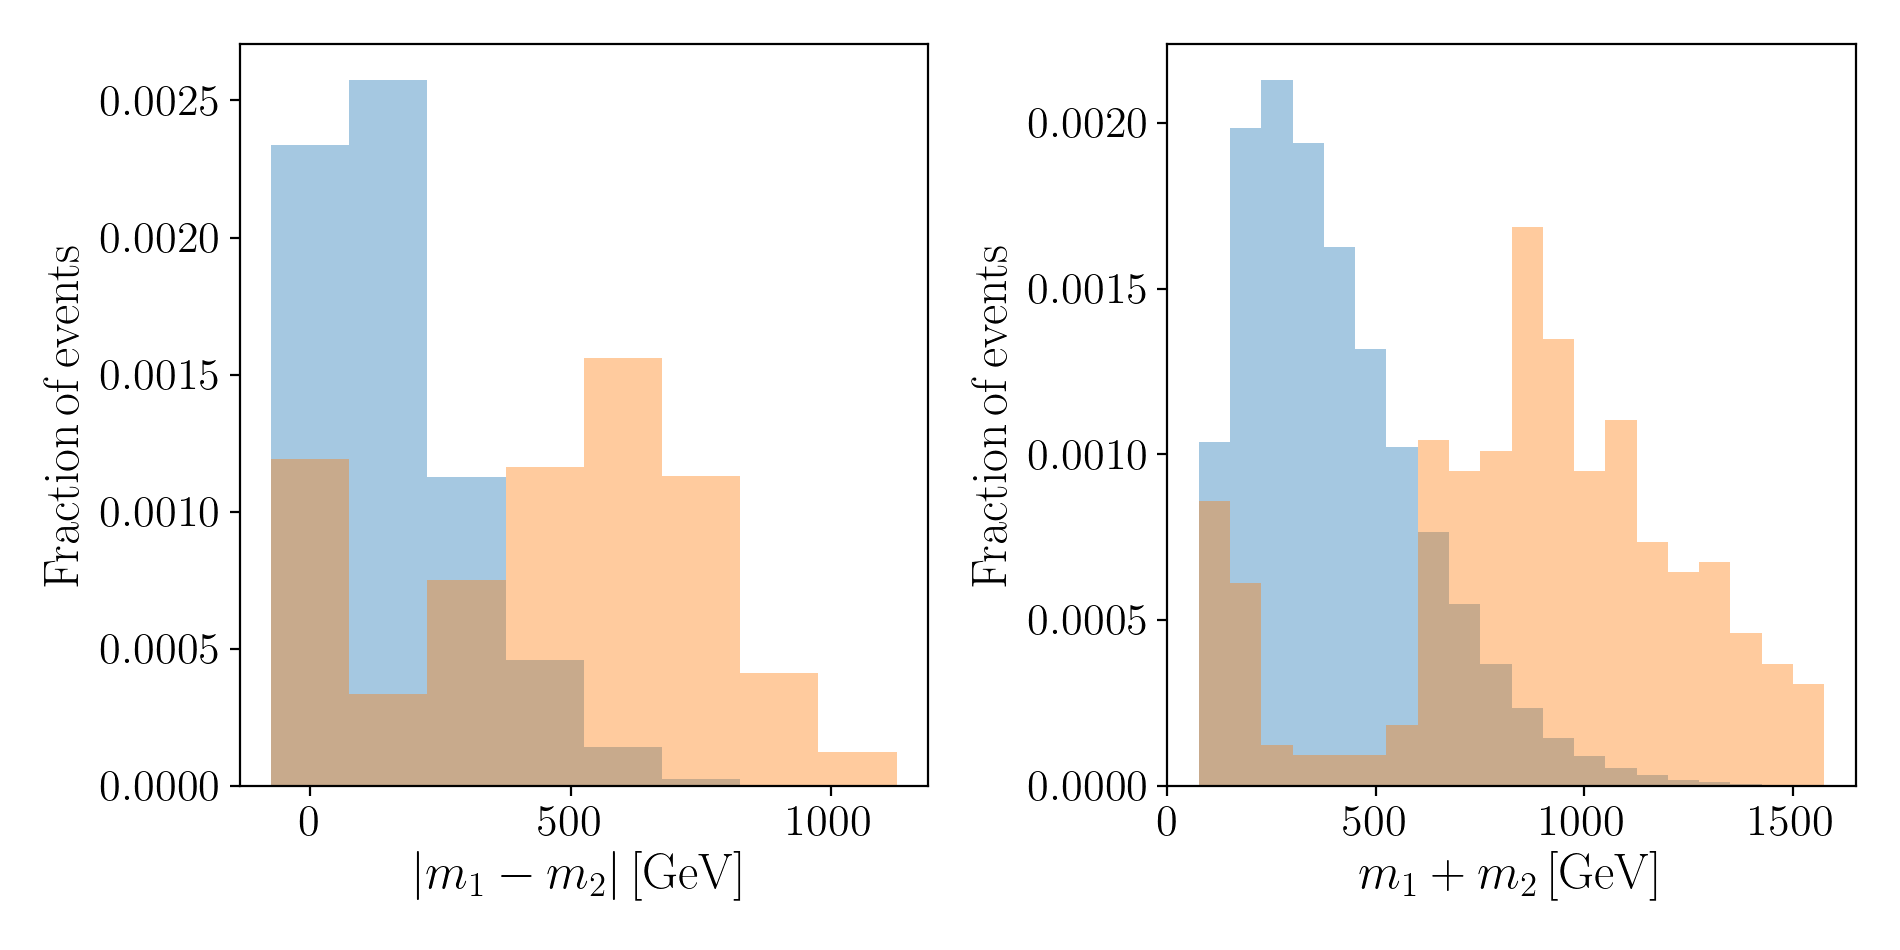

In [22]:
plt.figure(3, figsize=(9.5, 4.75))

df_2_cut = ((df_2['pca'] > np.quantile(df_2['pca'], 0.99))
            & (df_2['mass_jj'] > signal_region_min)
            & (df_2['mass_jj'] < signal_region_max))

plt.subplot(1, 2, 1)
plt.hist(df_2['|mass_1-mass_2|'], density=True, alpha=0.4, bins=np.arange(-75, 1275, 150))
plt.hist(df_2[df_2_cut]['|mass_1-mass_2|'], density=True, alpha=0.4, bins=np.arange(-75, 1275, 150))
plt.xlabel(r'$|m_1 - m_2|\, \rm [GeV]$')
plt.ylabel(r'$\rm Fraction\, of\, events$')

plt.subplot(1, 2, 2)
plt.hist(df_2['mass_1+mass_2'], density=True, alpha=0.4, bins=np.arange(75, 1600, 75))
plt.hist(df_2[df_2_cut]['mass_1+mass_2'], density=True, alpha=0.4, bins=np.arange(75, 1600, 75))
plt.xlabel(r'$m_1 + m_2\, \rm [GeV]$')
plt.ylabel(r'$\rm Fraction\, of\, events$')

plt.tight_layout(True)
plt.show()

Based on the above:

$m_1 + m_2 = 850.0 \pm 37.5$ GeV, and $|m_1 - m_2| = 650 \pm 75$ GeV where the uncertainties are half the bin width

Assuming without loss of generality $m_1 > m_2$ this yields

$m_1 = 750 \pm 42$ GeV, and $m_2 = 125 \pm 42$ GeV

<IPython.core.display.Javascript object>


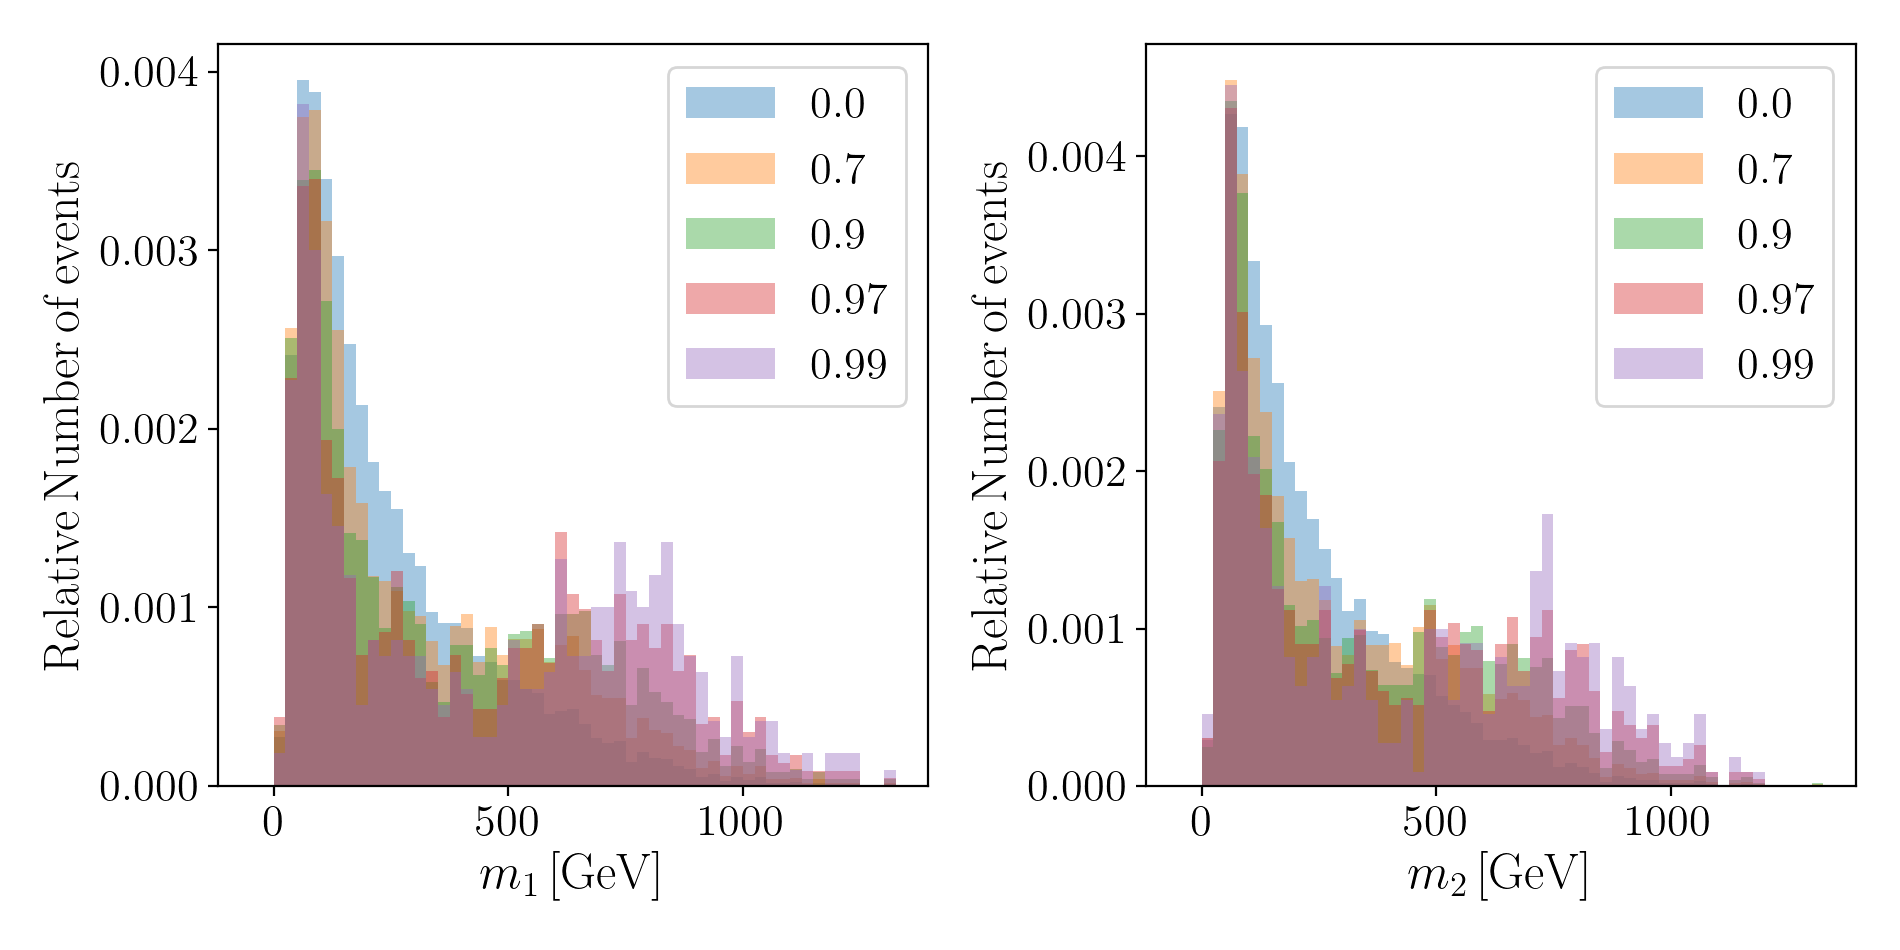

In [23]:
plt.figure(4, figsize=(9.5, 4.75))

plt.subplot(1, 2, 1)
for q in od_quantiles:
    cond1 = df_2['pca'] > np.quantile(df_2['pca'], q)
    cond2 = df_2['mass_jj'] > signal_region_min
    cond3 = df_2['mass_jj'] < signal_region_max
    plt.hist(df_2[cond1 & cond2 & cond3]['mass_1'], 
             density=True,
             bins=np.arange(-50, 1350, 25), 
             alpha=0.4,
             label=r'${}$'.format(q))
plt.xlabel(r'$m_1\, \rm [GeV]$')
plt.ylabel(r'$\rm Relative\, Number\, of\, events$')
plt.legend()

plt.subplot(1, 2, 2)
for q in od_quantiles:
    cond1 = df_2['pca'] > np.quantile(df_2['pca'], q)
    cond2 = df_2['mass_jj'] > signal_region_min
    cond3 = df_2['mass_jj'] < signal_region_max
    plt.hist(df_2[cond1 & cond2 & cond3]['mass_2'],
             density=True,
             bins=np.arange(-50, 1350, 25), 
             alpha=0.4,
             label=r'${}$'.format(q))
plt.xlabel(r'$m_2\, \rm [GeV]$')
plt.ylabel(r'$\rm Relative\, Number\, of\, events$')
plt.legend()

plt.tight_layout(True)
plt.show()

Looking at the masses themselves, it's a bit messy, but the 725 GeV peak is there

Using $N$-subjetiness to determine the decay products of the daughter particles. Both appear to primarily decay to two jets based on the low values for $\tau_{21}$ and the typical of QCD values for $\tau_{32}$ and $\tau_{43}$

<IPython.core.display.Javascript object>


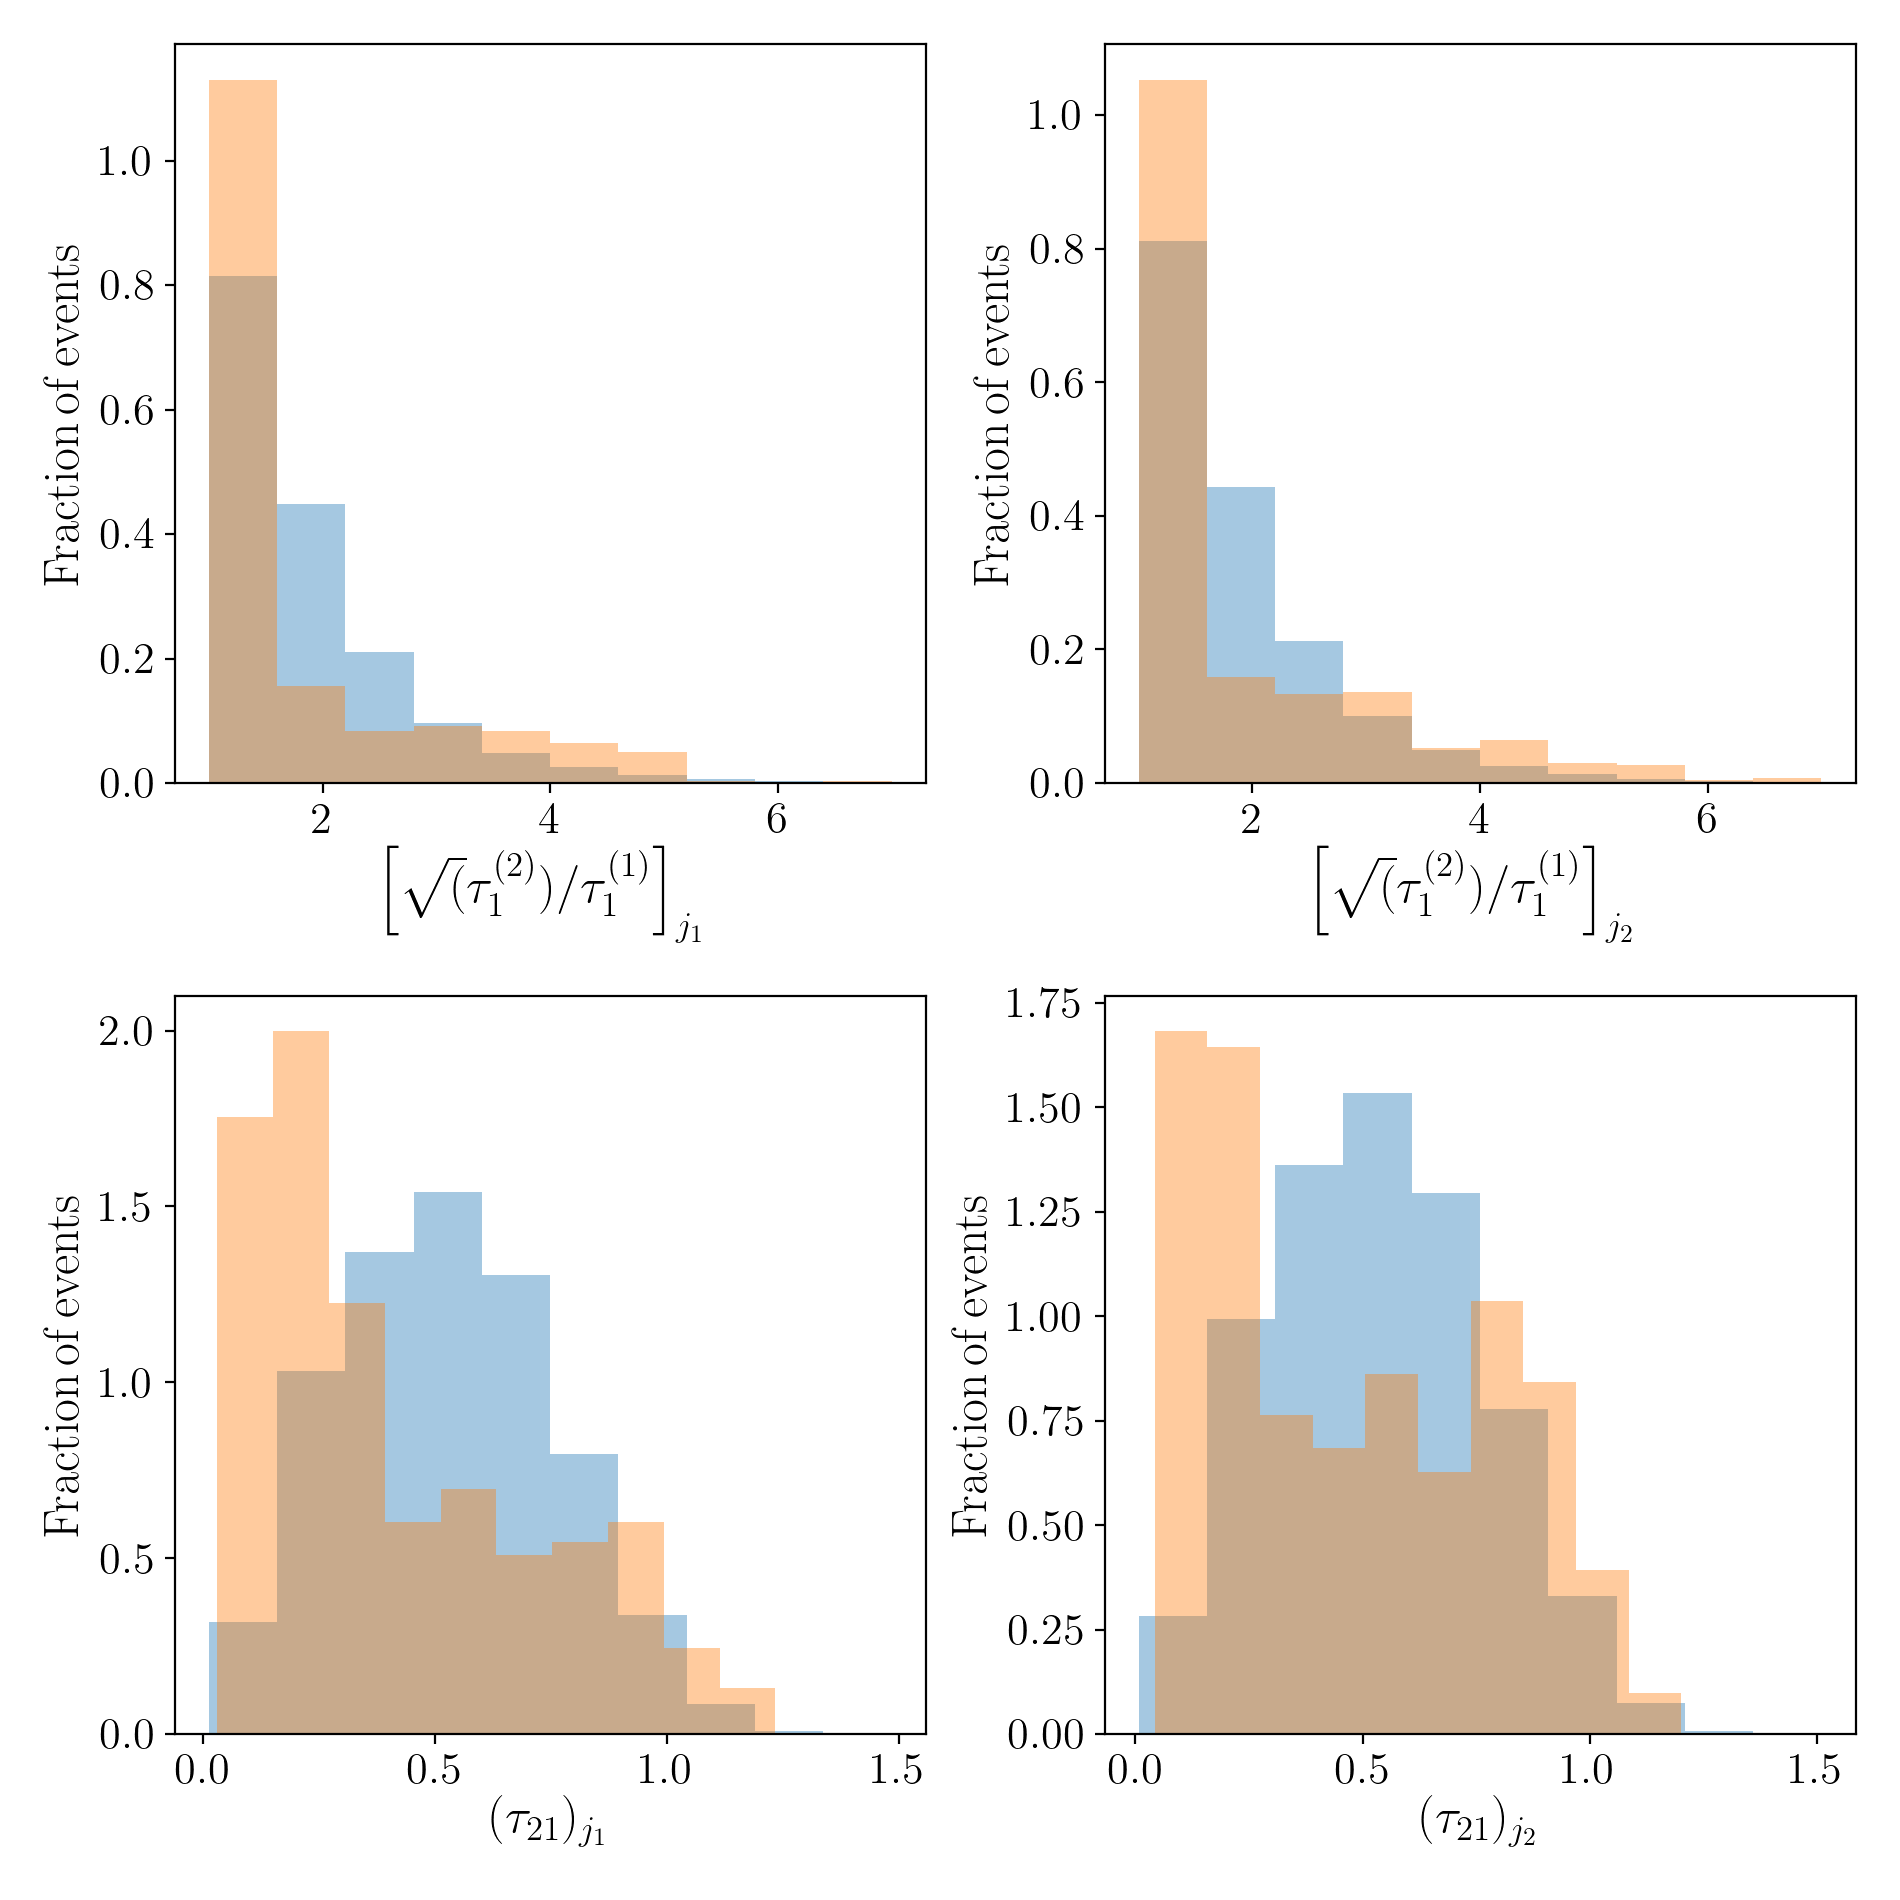

In [24]:
plt.figure(5, figsize=(9.5, 9.5))

df_2_cut = ((df_2['pca'] > np.quantile(df_2['pca'], 0.99))
            & (df_2['mass_jj'] > signal_region_min)
            & (df_2['mass_jj'] < signal_region_max))

plt.subplot(2, 2, 1)
plt.hist(df_2['sqrt(tau1(2))/tau1(1)_1'], density=True, range=(1, 7), alpha=0.4)
plt.hist(df_2[df_2_cut]['sqrt(tau1(2))/tau1(1)_1'], density=True, range=(1, 7), alpha=0.4)
plt.xlabel(r'$\left[\sqrt(\tau_1^{(2)})/\tau_1^{(1)}\right]_{j_1}$')
plt.ylabel(r'$\rm Fraction\, of\, events$')

plt.subplot(2, 2, 2)
plt.hist(df_2['sqrt(tau1(2))/tau1(1)_2'], density=True, range=(1, 7), alpha=0.4)
plt.hist(df_2[df_2_cut]['sqrt(tau1(2))/tau1(1)_2'], density=True, range=(1, 7), alpha=0.4)
plt.xlabel(r'$\left[\sqrt(\tau_1^{(2)})/\tau_1^{(1)}\right]_{j_2}$')
plt.ylabel(r'$\rm Fraction\, of\, events$')

plt.subplot(2, 2, 3)
plt.hist(df_2['tau21_1'], density=True, alpha=0.4)
plt.hist(df_2[df_2_cut]['tau21_1'], density=True, alpha=0.4)
plt.xlabel(r'$(\tau_{21})_{j_1}$')
plt.ylabel(r'$\rm Fraction\, of\, events$')

plt.subplot(2, 2, 4)
plt.hist(df_2['tau21_2'], density=True, alpha=0.4)
plt.hist(df_2[df_2_cut]['tau21_2'], density=True, alpha=0.4)
plt.xlabel(r'$(\tau_{21})_{j_2}$')
plt.ylabel(r'$\rm Fraction\, of\, events$')

plt.tight_layout(True)
plt.show()

<IPython.core.display.Javascript object>


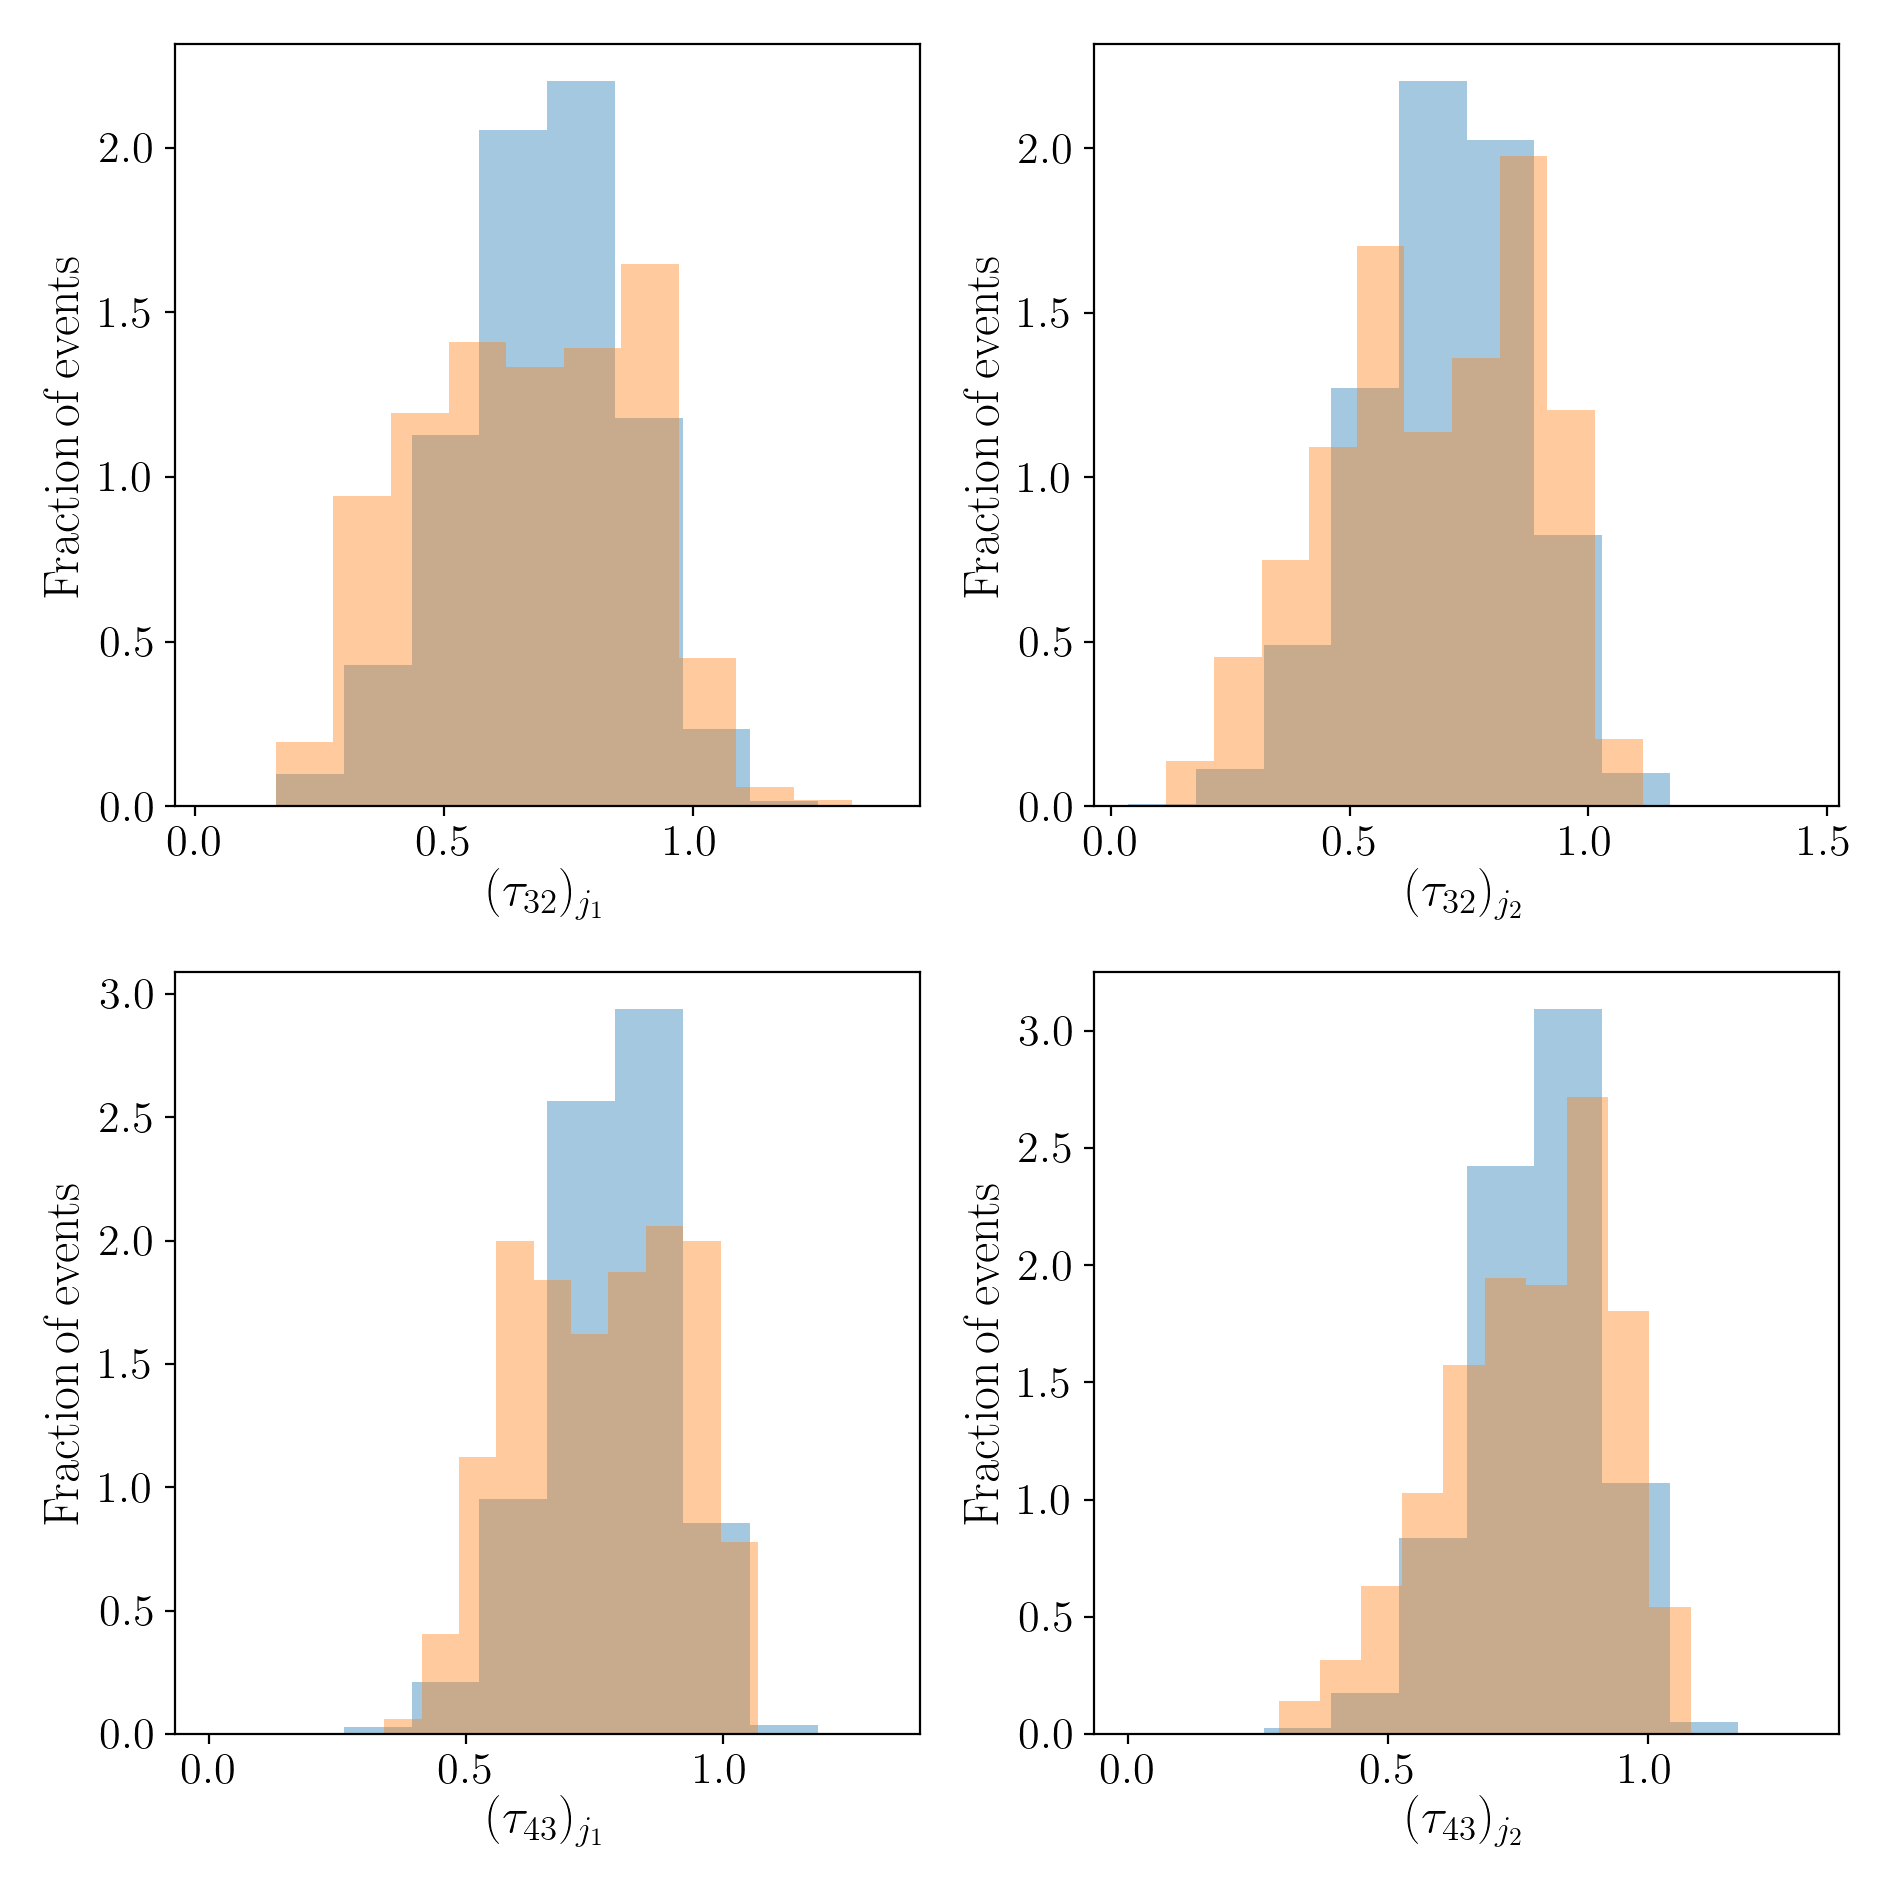

In [25]:
plt.figure(6, figsize=(9.5, 9.5))

df_2_cut = ((df_2['pca'] > np.quantile(df_2['pca'], 0.99))
            & (df_2['mass_jj'] > signal_region_min)
            & (df_2['mass_jj'] < signal_region_max))

plt.subplot(2, 2, 1)
plt.hist(df_2['tau32_1'], alpha=0.4, density=True)
plt.hist(df_2[df_2_cut]['tau32_1'], alpha=0.4, density=True)
plt.xlabel(r'$(\tau_{32})_{j_1}$')
plt.ylabel(r'$\rm Fraction\, of\, events$')

plt.subplot(2, 2, 2)
plt.hist(df_2['tau32_2'], alpha=0.4, density=True)
plt.hist(df_2[df_2_cut]['tau32_2'], alpha=0.4, density=True)
plt.xlabel(r'$(\tau_{32})_{j_2}$')
plt.ylabel(r'$\rm Fraction\, of\, events$')

plt.subplot(2, 2, 3)
plt.hist(df_2['tau43_1'], alpha=0.4, density=True)
plt.hist(df_2[df_2_cut]['tau43_1'], alpha=0.4, density=True)
plt.xlabel(r'$(\tau_{43})_{j_1}$')
plt.ylabel(r'$\rm Fraction\, of\, events$')

plt.subplot(2, 2, 4)
plt.hist(df_2['tau43_2'], alpha=0.4, density=True)
plt.hist(df_2[df_2_cut]['tau43_2'], alpha=0.4, density=True)
plt.xlabel(r'$(\tau_{43})_{j_2}$')
plt.ylabel(r'$\rm Fraction\, of\, events$')

plt.tight_layout(True)
plt.show()